# Import Dependencies

In [107]:
import numpy as np
import pandas as pd
import gzip
import json
import os
import gzip
import json
from pprint import pprint
import os
import pandas as pd
from pprint import pprint
import emoji
import unicodedata
import string
from typing import List, Optional

In [108]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itsmm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Influencer Category Classification



1.   Read Data
2.   Preprocess Data
3.   Prepare Model
4.   Predict Test Data
4.   Save outputs



In [109]:
import re
import emoji
from typing import List, Optional
import unicodedata
import string

def extract_hashtags(text: str) -> List[str]:
    """Extract hashtags from text while preserving the actual terms."""
    return re.findall(r'#(\w+)', text)

def extract_mentions(text: str) -> List[str]:
    """Extract mentions from text."""
    return re.findall(r'@(\w+)', text)

def count_emojis(text: str) -> int:
    """Count the number of emojis in text."""
    return sum(1 for char in text if char in emoji.EMOJI_DATA)

def extract_emojis(text: str) -> List[str]:
    """Extract emojis from text."""
    return [c for c in text if c in emoji.EMOJI_DATA]

def preprocess_text(text: str, remove_emojis: bool = False) -> dict:
    """
    Enhanced text preprocessing for social media content.
    Returns both cleaned text and extracted features.
    """
    if not isinstance(text, str) or text is None:
        return {
            'cleaned_text': '',
            'hashtags': [],
            'mentions': [],
            'emoji_count': 0,
            'emojis': [],
            'url_count': len(re.findall(r'http\S+|www\S+', text or '')),
            'text_length': 0
        }

    # Store original length
    original_length = len(text)

    # Extract features before cleaning
    hashtags = extract_hashtags(text)
    mentions = extract_mentions(text)
    emojis = extract_emojis(text)
    emoji_count = len(emojis)
    url_count = len(re.findall(r'http\S+|www\S+', text))

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove punctuation but keep hashtags and mentions
    punctuation = string.punctuation.replace('#', '').replace('@', '')
    text = ''.join(ch for ch in text if ch not in punctuation)

    # Handle emojis
    if remove_emojis:
        text = emoji.replace_emoji(text, '')
    
    # Normalize unicode characters
    text = unicodedata.normalize('NFKC', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return {
        'cleaned_text': text,
        'hashtags': hashtags,
        'mentions': mentions,
        'emoji_count': emoji_count,
        'emojis': emojis,
        'url_count': url_count,
        'text_length': original_length
    }

def aggregate_user_posts(posts: List[dict]) -> dict:
    """
    Aggregate features from multiple posts of a user.
    """
    all_text = []
    total_hashtags = []
    total_mentions = []
    total_emojis = []
    text_features = {
        'emoji_count': 0,
        'url_count': 0,
        'text_length': 0
    }

    for post in posts:
        caption = post.get('caption', '')
        if caption:
            processed = preprocess_text(caption)
            all_text.append(processed['cleaned_text'])
            total_hashtags.extend(processed['hashtags'])
            total_mentions.extend(processed['mentions'])
            total_emojis.extend(processed['emojis'])
            text_features['emoji_count'] += processed['emoji_count']
            text_features['url_count'] += processed['url_count']
            text_features['text_length'] += processed['text_length']

    return {
        'combined_text': ' '.join(all_text),
        'unique_hashtags': list(set(total_hashtags)),
        'unique_mentions': list(set(total_mentions)),
        'unique_emojis': list(set(total_emojis)),
        'hashtag_count': len(total_hashtags),
        'mention_count': len(total_mentions),
        'avg_text_length': text_features['text_length'] / len(posts) if posts else 0,
        'avg_emoji_count': text_features['emoji_count'] / len(posts) if posts else 0,
        'avg_url_count': text_features['url_count'] / len(posts) if posts else 0
    }

In [110]:
# Step 1: Define File Paths Dynamically
# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the training directory
training_dir = os.path.join(data_dir, 'training')

# File path for 'train-classification.csv'
train_classification_path = os.path.join(training_dir, 'train-classification.csv')

# Step 2: Load Data Dynamically
train_classification_df = pd.read_csv(train_classification_path)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Step 3: Unify Labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)

# Step 4: Create User-to-Category Mapping
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

# Step 5: Verify Output
print("First few rows of the training classification DataFrame:")
train_classification_df.head()

First few rows of the training classification DataFrame:


,user_id,category
0,taskirancemal,mom and children
1,tam_kararinda,food
2,spart4nn,food
3,sosyalyiyiciler,food
4,sonaydizdarahad,mom and children


In [111]:
# stats about the labels
train_classification_df.groupby("category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [112]:
username2_category["kod8net"]

'tech'

In [113]:
# Step 1: Define File Paths Dynamically
# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the training directory
training_dir = os.path.join(data_dir, 'training')

# File path for 'training-dataset.jsonl.gz'
train_data_path = os.path.join(training_dir, 'training-dataset.jsonl.gz')

# Step 2: Initialize Dictionaries for Data
username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()

# Step 3: Process Data from 'training-dataset.jsonl.gz'
with gzip.open(train_data_path, "rt", encoding="utf-8") as fh:
    for line in fh:
        sample = json.loads(line)

        profile = sample["profile"]
        username = profile.get("username", "").strip()  # Handle missing or empty usernames
        if not username:
            continue  # Skip if username is missing or empty

        if username in username2_category:
            # Train data info
            username2posts_train[username] = sample["posts"]
            username2profile_train[username] = profile
        else:
            # Test data info
            username2posts_test[username] = sample["posts"]
            username2profile_test[username] = profile

# Step 4: Verify Output
print(f"Number of Training Users: {len(username2posts_train)}")
print(f"Number of Testing Users: {len(username2posts_test)}")

Number of Training Users: 2741
Number of Testing Users: 2674


In [114]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [115]:
test_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,None,1265,665,True,False,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,None,28025,4,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Initialize containers for features and labels
train_features = []
train_usernames = []
train_text_features = []

# Process training data
for username, posts in username2posts_train.items():
    train_usernames.append(username)
    
    # Aggregate features from all posts
    user_features = aggregate_user_posts(posts)
    
    # Store the combined cleaned text for TF-IDF
    train_features.append(user_features['combined_text'])
    
    # Store additional text features
    train_text_features.append({
        'hashtag_count': user_features['hashtag_count'],
        'mention_count': user_features['mention_count'],
        'avg_text_length': user_features['avg_text_length'],
        'avg_emoji_count': user_features['avg_emoji_count'],
        'avg_url_count': user_features['avg_url_count'],
        'unique_hashtags_count': len(user_features['unique_hashtags']),
        'unique_mentions_count': len(user_features['unique_mentions']),
        'unique_emojis_count': len(user_features['unique_emojis'])
    })

# Convert additional features to DataFrame
train_text_features_df = pd.DataFrame(train_text_features)

# Create TF-IDF features
vectorizer = TfidfVectorizer(
    stop_words=turkish_stopwords,
    max_features=5000,
    ngram_range=(1, 2),  # Include bigrams
    min_df=5,  # Minimum document frequency
    max_df=0.9  # Maximum document frequency
)

# Fit and transform the training data
x_post_train = vectorizer.fit_transform(train_features)

# Create labels
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]

# Initialize test data containers
test_features = []
test_text_features = []
test_usernames = []  # Initialize the test_usernames list

# Process test data similarly
for username, posts in username2posts_test.items():
    test_usernames.append(username)
    
    # Aggregate features from all posts
    user_features = aggregate_user_posts(posts)
    
    # Store the combined cleaned text for TF-IDF
    test_features.append(user_features['combined_text'])
    
    # Store additional text features
    test_text_features.append({
        'hashtag_count': user_features['hashtag_count'],
        'mention_count': user_features['mention_count'],
        'avg_text_length': user_features['avg_text_length'],
        'avg_emoji_count': user_features['avg_emoji_count'],
        'avg_url_count': user_features['avg_url_count'],
        'unique_hashtags_count': len(user_features['unique_hashtags']),
        'unique_mentions_count': len(user_features['unique_mentions']),
        'unique_emojis_count': len(user_features['unique_emojis'])
    })

# Convert additional features to DataFrame
test_text_features_df = pd.DataFrame(test_text_features)

# Transform test data using the same vectorizer
x_post_test = vectorizer.transform(test_features)

In [117]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [118]:
import scipy.sparse
import numpy as np
import re

def engineer_profile_features(profile_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create advanced features from Instagram profile metadata.
    """
    # Create a copy to avoid modifying original data
    df = profile_df.copy()
    
    # Convert numeric columns
    df['follower_count'] = pd.to_numeric(df['follower_count'], errors='coerce').fillna(0)
    df['following_count'] = pd.to_numeric(df['following_count'], errors='coerce').fillna(0)
    
    # Engagement and Following Metrics
    df['follower_following_ratio'] = df['follower_count'] / (df['following_count'] + 1)
    df['engagement_potential'] = np.log1p(df['follower_count'].astype(float))
    
    # Convert boolean columns to int
    bool_columns = ['is_business_account', 'is_private', 'is_verified']
    for col in bool_columns:
        if col in df.columns:
            df[col] = df[col].astype(int)
    
    # Account Status Features
    df['is_professional'] = (df['is_business_account'].astype(bool) | 
                           df['category_name'].notna() | 
                           df['business_category_name'].notna()).astype(int)
    
    # Biography Features
    def process_biography(bio):
        if not isinstance(bio, str) or pd.isna(bio):
            return {
                'bio_length': 0,
                'bio_has_email': 0,
                'bio_has_external_link': 0,
                'bio_emoji_count': 0,
                'bio_hashtag_count': 0,
                'bio_mention_count': 0
            }
        
        processed = preprocess_text(bio)
        return {
            'bio_length': len(bio),
            'bio_has_email': int(bool(re.search(r'[\w\.-]+@[\w\.-]+', bio))),
            'bio_has_external_link': int(bool(re.search(r'http\S+|www\S+', bio))),
            'bio_emoji_count': processed['emoji_count'],
            'bio_hashtag_count': len(processed['hashtags']),
            'bio_mention_count': len(processed['mentions'])
        }
    
    # Process biographies
    bio_features = df['biography'].apply(process_biography).apply(pd.Series)
    df = pd.concat([df, bio_features], axis=1)
    
    # Category Processing
    def clean_category(cat):
        if pd.isna(cat):
            return 'unknown'
        return str(cat).lower().strip()
    
    # Create dummy variables for categories
    df['clean_category'] = df['category_name'].apply(clean_category)
    category_dummies = pd.get_dummies(df['clean_category'], prefix='category')
    df = pd.concat([df, category_dummies], axis=1)
    
    # Create numerical features
    df['name_length'] = df['full_name'].str.len().fillna(0).astype(float)
    df['username_length'] = df['username'].str.len().fillna(0).astype(float)
    
    # Composite Features
    df['profile_completion_score'] = (
        (df['biography'].notna() & (df['biography'] != '')).astype(int) +
        (df['profile_pic_url'].notna()).astype(int) +
        (df['category_name'].notna()).astype(int) +
        df['is_business_account'].astype(int)
    )
    
    # Drop non-numeric columns and text columns
    columns_to_drop = ['biography', 'profile_pic_url', 'business_category_name', 
                      'overall_category_name', 'category_name', 'profile_picture_base64',
                      'username', 'full_name', 'clean_category', 'id']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Convert all remaining columns to float
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(float)
    
    return df

def combine_features(profile_features: pd.DataFrame, 
                    text_features: pd.DataFrame, 
                    tfidf_features: scipy.sparse.csr_matrix) -> scipy.sparse.csr_matrix:
    """
    Combine all feature sets into a single sparse matrix.
    """
    # Ensure all features are numeric
    profile_features = profile_features.astype(float)
    text_features = text_features.astype(float)
    
    # Convert to sparse matrices
    profile_sparse = scipy.sparse.csr_matrix(profile_features.values)
    text_sparse = scipy.sparse.csr_matrix(text_features.values)
    
    # Combine all features
    combined_features = scipy.sparse.hstack([tfidf_features, profile_sparse, text_sparse])
    
    return combined_features

# Process training data
print("Processing training data...")
train_profile_features = engineer_profile_features(train_profile_df)
x_train_combined = combine_features(train_profile_features, train_text_features_df, x_post_train)

# Process test data
print("Processing test data...")
test_profile_features = engineer_profile_features(test_profile_df)
x_test_combined = combine_features(test_profile_features, test_text_features_df, x_post_test)

print(f"Final feature matrix shapes - Training: {x_train_combined.shape}, Testing: {x_test_combined.shape}")

Processing training data...
Processing test data...
Final feature matrix shapes - Training: (2741, 5389), Testing: (2674, 5377)


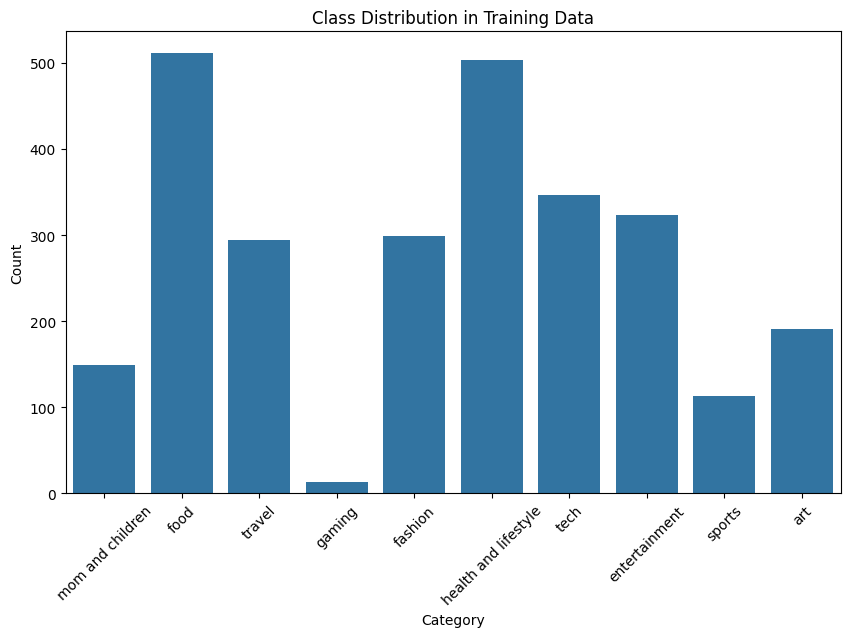

In [119]:
# Analyze class distribution
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming `train_classification.csv` is already loaded as `train_data`
class_counts = Counter(train_classification_df['category'])

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Training Data")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [120]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classification_df['category']),
    y=train_classification_df['category']
)

# Map weights to corresponding classes
class_weights_dict = dict(zip(np.unique(train_classification_df['category']), class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {'art': 1.4356020942408376, 'entertainment': 0.8489164086687306, 'fashion': 0.9170568561872909, 'food': 0.5365949119373777, 'gaming': 21.092307692307692, 'health and lifestyle': 0.5451292246520875, 'mom and children': 1.840268456375839, 'sports': 2.426548672566372, 'tech': 0.792485549132948, 'travel': 0.9326530612244898}


In [121]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['00', '01', '02', ..., 'şıklık', 'şıklığı', 'به'], dtype=object)

In [122]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

,00,01,02,0212,0216,0232,0264,03,0312,0380,...,şubeleri,şubemiz,şubesi,şöleni,şöyle,şık,şık bir,şıklık,şıklığı,به
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.046801,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [123]:
df_tfidf.shape

(2741, 5000)

In [124]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

In [125]:
x_train.shape

(2192, 5000)

In [126]:
x_val.shape

(549, 5000)

# Naive Base Classifier

### Now we can pass the numerical values to a classifier, Let's try Naive Base!


In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Instantiate Logistic Regression with class weights
model = LogisticRegression(
    class_weight=class_weights_dict,  # Use computed class weights
    max_iter=1000,                    # Increase iterations for convergence
    random_state=42                   # Set a random state for reproducibility
)

# Train the model
model.fit(x_train, y_train)

# Evaluate on training data
y_train_pred = model.predict(x_train)
print("Training Data:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

# Evaluate on validation data
y_val_pred = model.predict(x_val)
print("Validation Data:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))

Training Data:
Accuracy: 0.8590328467153284

Classification Report:
                      precision    recall  f1-score   support

                 art       0.80      0.83      0.82       153
       entertainment       0.90      0.77      0.83       258
             fashion       0.80      0.92      0.86       239
                food       0.95      0.89      0.92       409
              gaming       1.00      1.00      1.00        10
health and lifestyle       0.89      0.76      0.82       402
    mom and children       0.80      0.93      0.86       119
              sports       0.83      0.97      0.89        90
                tech       0.82      0.92      0.87       277
              travel       0.83      0.86      0.84       235

            accuracy                           0.86      2192
           macro avg       0.86      0.89      0.87      2192
        weighted avg       0.86      0.86      0.86      2192

Validation Data:
Accuracy: 0.6502732240437158

Classification

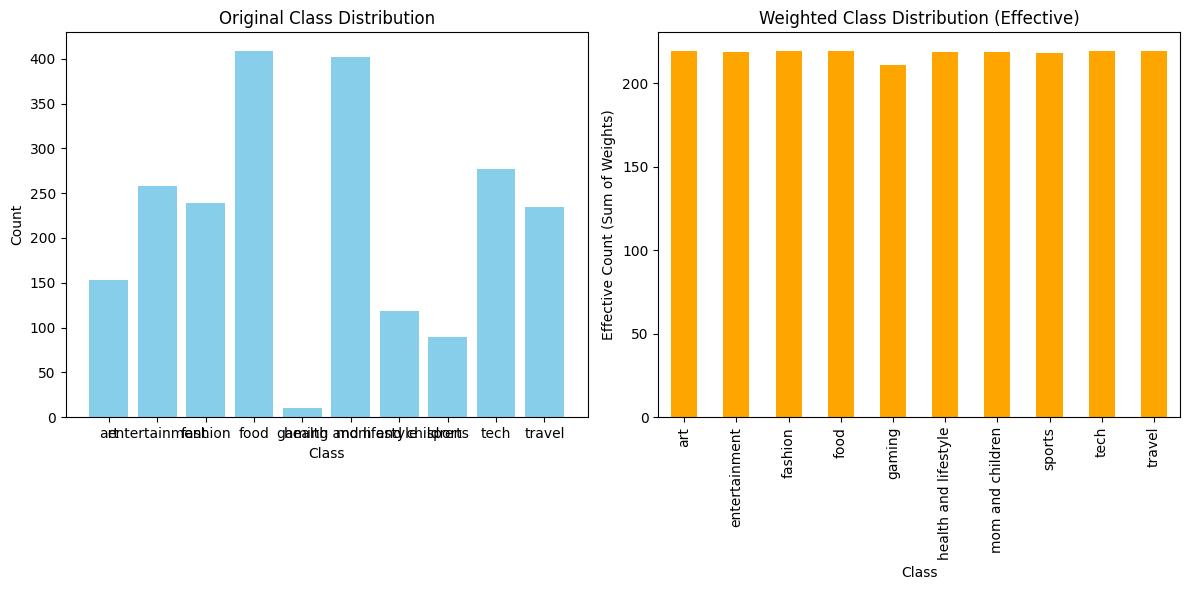

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate sample weights
y_train_array = np.array(y_train)  # Ensure y_train is a numpy array
sample_weights = np.array([class_weights_dict[label] for label in y_train_array])

# Create a DataFrame for visualization
class_counts = pd.DataFrame({
    'Class': y_train,
    'Weight': sample_weights
})

# Group by class and sum the weights
weighted_counts = class_counts.groupby('Class')['Weight'].sum()

# Plot the original and weighted class distributions
plt.figure(figsize=(12, 6))

# Original class distribution
plt.subplot(1, 2, 1)
original_counts = np.unique(y_train, return_counts=True)
plt.bar(original_counts[0], original_counts[1], color='skyblue')
plt.title("Original Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

# Weighted class distribution
plt.subplot(1, 2, 2)
weighted_counts.sort_index().plot(kind='bar', color='orange')
plt.title("Weighted Class Distribution (Effective)")
plt.xlabel("Class")
plt.ylabel("Effective Count (Sum of Weights)")

plt.tight_layout()
plt.show()


In [129]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [130]:
#@title Train Data
y_train_pred = model.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Accuracy: 0.655565693430657

Classification Report:
                      precision    recall  f1-score   support

                 art       1.00      0.08      0.16       153
       entertainment       0.63      0.56      0.59       258
             fashion       0.79      0.74      0.76       239
                food       0.81      0.88      0.84       409
              gaming       0.00      0.00      0.00        10
health and lifestyle       0.50      0.85      0.63       402
    mom and children       0.87      0.11      0.19       119
              sports       1.00      0.06      0.11        90
                tech       0.74      0.82      0.78       277
              travel       0.59      0.68      0.63       235

            accuracy                           0.66      2192
           macro avg       0.69      0.48      0.47      2192
        weighted avg       0.72      0.66      0.62      2192



In [131]:
#@title Validation Data
y_val_pred = model.predict(x_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))

Accuracy: 0.5792349726775956

Classification Report:
                      precision    recall  f1-score   support

                 art       0.50      0.03      0.05        38
       entertainment       0.47      0.37      0.41        65
             fashion       0.64      0.57      0.60        60
                food       0.78      0.86      0.82       102
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.41      0.79      0.54       100
    mom and children       0.00      0.00      0.00        30
              sports       1.00      0.04      0.08        23
                tech       0.81      0.81      0.81        69
              travel       0.51      0.59      0.55        59

            accuracy                           0.58       549
           macro avg       0.51      0.41      0.39       549
        weighted avg       0.58      0.58      0.53       549



In [132]:
# Step 1: Define File Paths Dynamically
# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the testing directory
testing_dir = os.path.join(data_dir, 'testing')

# File path for 'test-classification-round1.dat'
test_data_path = os.path.join(testing_dir, 'test-classification-round1.dat')

# Step 2: Preview First 5 Lines of the Test File
with open(test_data_path, "rt", encoding="utf-8") as fh:
    for i, line in enumerate(fh):
        print(line.strip())
        if i == 4:  # Print only the first 5 lines
            break

print("*****")

# Step 3: Extract Usernames from Test Data
test_unames = []
with open(test_data_path, "rt", encoding="utf-8") as fh:
    for line in fh:
        test_unames.append(line.strip())

# Step 4: Verify Output
print(test_unames[:5])  # Display the first 5 usernames

ozhotelstr
elleturkiye
sozerinsaatorhangazi
sanliurfapiazzaavym
rusanozden
*****
['ozhotelstr', 'elleturkiye', 'sozerinsaatorhangazi', 'sanliurfapiazzaavym', 'rusanozden']


In [133]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)


test_unames.remove("screenname")

screenname


In [134]:
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.head(2)

,00,01,02,0212,0216,0232,0264,03,0312,0380,...,şubeleri,şubemiz,şubesi,şöleni,şöyle,şık,şık bir,şıklık,şıklığı,به
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.025419,0.010901,0.0,0.0,0.0,0.0


In [135]:
test_pred = model.predict(df_test)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = test_pred[index]

In [136]:
with open("output.json", "w") as of:
  json.dump(output, of, indent=4)

# Like Count Prediction


Here, we use the average like_count of the user's previous posts to predict each post's like_count

In [137]:
def predict_like_count(username, current_post=None):
  def get_avg_like_count(posts:list):
    total = 0.
    for post in posts:
      if current_post is not None and post["id"] == current_post["id"]:
        continue

      like_count = post.get("like_count", 0)
      if like_count is None:
        like_count = 0
      total += like_count

    if len(posts) == 0:
      return 0.

    return total / len(posts)

  if username in username2posts_train:
    return get_avg_like_count(username2posts_train[username])
  elif username in username2posts_test:
    return get_avg_like_count(username2posts_test[username])
  else:
    print(f"No data available for {username}")
    return -1

In [138]:
def log_mse_like_counts(y_true, y_pred):
  """
  Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).

  Parameters:
  - y_true: array-like, actual like counts
  - y_pred: array-like, predicted like counts

  Returns:
  - log_mse: float, Log Mean Squared Error
  """
  # Ensure inputs are numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Log transformation: log(like_count + 1)
  log_y_true = np.log1p(y_true)
  log_y_pred = np.log1p(y_pred)

  # Compute squared errors
  squared_errors = (log_y_true - log_y_pred) ** 2

  # Return the mean of squared errors
  return np.mean(squared_errors)

In [139]:
#@title Train Dataset evaluation

y_like_count_train_true = []
y_like_count_train_pred = []
for uname, posts in username2posts_train.items():
  for post in posts:
    pred_val = predict_like_count(uname, post)
    true_val = post.get("like_count", 0)
    if true_val is None:
      true_val = 0

    y_like_count_train_true.append(true_val)
    y_like_count_train_pred.append(pred_val)

print(f"Log MSE Train= {log_mse_like_counts(y_like_count_train_true, y_like_count_train_pred)}")

Log MSE Train= 1.2271047744059362


In [140]:
# Step 1: Define File Paths Dynamically
# Get the current notebook directory
current_notebook_dir = os.getcwd()

# Get the repo directory (assuming notebooks are inside the "notebooks" folder)
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Get the data directory
data_dir = os.path.join(repo_dir, 'data')

# Get the testing directory
testing_dir = os.path.join(data_dir, 'testing')

# File path for 'test-regression-round1.jsonl'
test_dataset_path = os.path.join(testing_dir, 'test-regression-round1.jsonl')

# File path for output
output_dir = os.path.join(data_dir, 'output')
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
output_file_path = os.path.join(output_dir, 'test-regression-round1.jsonl')

# Step 2: Process the Test Dataset
to_predict_like_counts_usernames = []
output_list = []

with open(test_dataset_path, "rt", encoding="utf-8") as fh:
    for line in fh:
        sample = json.loads(line)

        # Perform prediction
        pred_val = predict_like_count(sample["username"])  # Ensure `predict_like_count` is defined
        sample["like_count"] = int(pred_val)
        output_list.append(sample)

# Step 3: Save the Output to a File
with open(output_file_path, "wt", encoding="utf-8") as of:
    json.dump(output_list, of)

# Step 4: Output Verification
print(f"Processed data saved to: {output_file_path}")

Processed data saved to: c:\Users\itsmm\OneDrive\Desktop\CS412\CS412-InstagramInfluencersAnalysis\data\output\test-regression-round1.jsonl


In [141]:
# output_list first 3 items
pprint(output_list[:3])

[{'caption': 'KOZA 2023 2.si Damla’nın koleksiyonu, Latincede ‘Memento Mori’ '
             'olarak bilinen ‘ölümlü olduğunu hatırla’ anlamındaki ifadeden '
             'esinleniyor. Koleksiyon, hayatın ve ölümün, para, işçi, kral ve '
             'kraliçe kavramları üzerinden yaratıcı görünümlerle bir araya '
             'getirilmesini amaçlıyor. Ölüm sembollerinden esinlenen desenler '
             'kullanan Damla, “kağıt parçasından ibaret olmak” kavramını '
             'vurguluyor. Koleksiyon, yaşamın ve ölümün aynı anda ifade '
             'edilmesini hedefliyor; kırmızı ve mavi ışıklarla veya '
             'gözlüklerle görülen hologram efekti kullanılarak bu konsept '
             'sahneye taşınıyor. Kırmızı renk ölümü, mavi ise yaşamı '
             'simgeliyor. Koleksiyon, ofis giyimlerinden esinlenerek '
             'kravatlar, gömlekler ve evrak çantaları içeriyor. Klasik sivri '
             'burun çizmelerin üzerine spor ayakkabıların üst yüzeyi '
             'yerle